In [1]:
%reload_ext autoreload
%autoreload 2

from ripple_heterogeneity.utils import (
    functions,
    loading,
    batch_analysis,
    add_new_deep_sup,
)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nelpy as nel
from matplotlib.ticker import AutoMinorLocator
import os
from scipy import stats
import glob
import os
import pickle

functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

In [2]:
df = pd.read_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv")


In [8]:
def get_region_psth(
    basepath,
    putativeCellType="Pyr",
    target_regions=["CA1", "PFC", "EC1|EC2|EC3|EC4|EC5|MEC"],
):

    st, cell_metric = loading.load_spikes(
        basepath, brainRegion=target_regions, putativeCellType=putativeCellType
    )
    if st.isempty:
        return None
    
    ripples = loading.load_ripples_events(basepath)
    replays_epochs = nel.EpochArray([np.array([ripples.start, ripples.stop]).T])

    psth = functions.compute_psth(
        st.data, replays_epochs.starts, bin_width=0.01, n_bins=100
    )
    results = {"psth": psth, "cell_metric": cell_metric}
    return results

def load_results(save_path):
    sessions = glob.glob(os.path.join(save_path, "*.pkl"))
    psth_df = pd.DataFrame()
    cell_metrics = pd.DataFrame()
    for session in sessions:
        with open(session, "rb") as f:
            results = pickle.load(f)

        if results is None:
            continue

        if results["cell_metric"].shape[0] == 0:
            continue
        
        if results["cell_metric"].shape[0] != results["psth"].shape[1]:
            print("psth and cell_metric have different shapes")
            print(session)
        psth_df = pd.concat([psth_df, results["psth"]], axis=1, ignore_index=True)
        cell_metrics = pd.concat([cell_metrics, results["cell_metric"]], axis=0, ignore_index=True)
    return psth_df, cell_metrics

In [10]:
save_path = (
    r"Z:\home\ryanh\projects\ripple_heterogeneity\deep_sup_ripple_psth_negative_mod_v1"
)

batch_analysis.run(
    df,
    save_path,
    get_region_psth,
    parallel=True,
    overwrite=False,
    verbose=True,
    skip_if_error=False,
    target_regions="CA1",
)
psth_df, cell_metrics = load_results(save_path)

100%|██████████| 311/311 [03:12<00:00,  1.62it/s]


In [13]:
cell_metrics = add_new_deep_sup.deep_sup_from_deepSuperficialDistance(cell_metrics)


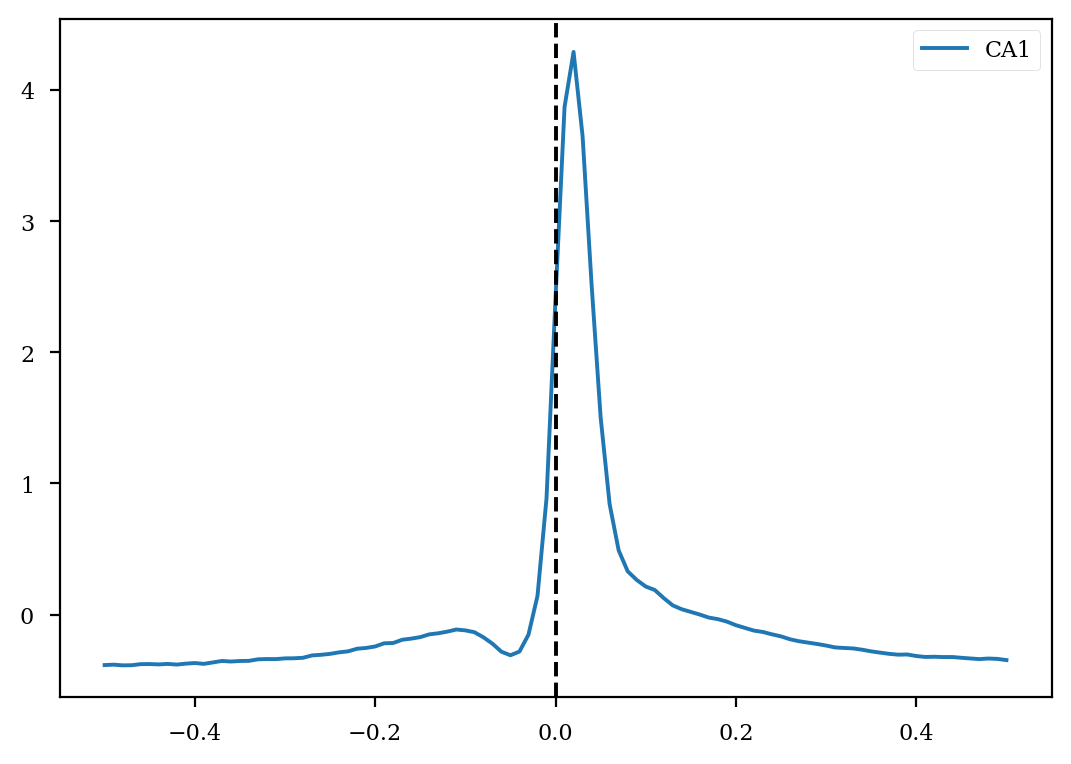

In [15]:
def plot_psth_mean(psth_df,cell_metrics, region_idx, label):


    psth = psth_df.values[:,cell_metrics.brainRegion.str.contains(region_idx).values]

    psth_z = stats.zscore(psth, axis=0)
    plt.plot(psth_df.index, np.nanmean(psth_z, axis=1), label=label)
    plt.fill_between(
        psth_df.index,
        np.nanmean(psth_z, axis=1) - np.nanstd(psth_z, axis=1) / np.sqrt(psth.shape[1]),
        np.nanmean(psth_z, axis=1) + np.nanstd(psth_z, axis=1) / np.sqrt(psth.shape[1]),
        alpha=0.5,
    )
    plt.axvline(x=0, color="k", linestyle="--")
    plt.legend()

plot_psth_mean(psth_df,cell_metrics, "CA1", "CA1")


In [28]:
from scipy.ndimage import gaussian_filter1d

def plot_psth_matrix(psth_df, cell_metrics, region_idx, label=None, ax=None, vmax=3, vmin=-3):

    psth = psth_df.values[:, cell_metrics.brainRegion.str.contains(region_idx).values]

    psth_smooth = gaussian_filter1d(psth, np.round(.020 / np.diff(psth_df.index)[0]),axis=0)

    # sort_idx = np.argsort(np.argmax(psth, axis=0))

    # max_mean_ratio = (psth_smooth[(psth_df.index > 0) & (psth_df.index < 0.1),:].max(axis=0) / psth_smooth.mean(axis=0))
    max_mean_ratio = (psth_smooth[(psth_df.index > 0) & (psth_df.index < 0.1),:].max(axis=0) / psth_smooth[(psth_df.index < -0.10),:].mean(axis=0))

    sort_idx = np.argsort(max_mean_ratio)

    if ax is None:
        plt.figure()
    ax = plt.gca()
    # sns.heatmap(
    #     stats.zscore(psth, axis=0)[:,sort_idx].T,
    #     ax=ax,
    #     cmap="bwr",
    #     vmax=3,
    #     vmin=-3,
    #     xticklabels=False,
    # )
    extent = [psth_df.index.min(), psth_df.index.max(), 0, psth.shape[1]]

    sm = ax.imshow(
        stats.zscore(psth_smooth, axis=0)[:, sort_idx].T,
        aspect="auto",
        interpolation="nearest",
        extent=extent,
        vmin=vmin,
        vmax=vmax,
        cmap="bwr"
    )

    ax.set_yticks([psth.shape[1]])

    ax.axvline(0, color="k", lw=1, ls="--")
    if label is not None:
        ax.set_title(label, fontsize=12)
    return sm

def confidence_intervals(X,conf=0.95):
    # remove nans
    X = X[np.sum(np.isnan(X),axis=1) == 0,:]
    # compute interval for each column
    interval = [stats.t.interval(conf, len(a) - 1, loc = np.mean(a), scale = stats.sem(a)) for a in X.T]
    interval = np.vstack(interval)
    lower = interval[:,0]
    upper = interval[:,1]
    return lower,upper
    
def std_upper_lower(X):
    upper = np.nanmean(X,axis=1) + np.nanstd(X,axis=1)
    lower = np.nanmean(X,axis=1) - np.nanstd(X,axis=1)
    return lower,upper

def get_center_val(psth_df, window=[0,0.1], smooth_sigma=0.02,zscore=True,smooth=True):
    # find cells within region
    psth = psth_df.values
    # standardize psth
    if zscore:
        psth = stats.zscore(psth, axis=0)
    # smooth over time
    if smooth:
        psth_smooth = gaussian_filter1d(
            psth, np.round(smooth_sigma / np.diff(psth_df.index)[0]), axis=0
        )
    else:
        psth_smooth = psth

    # pull out data within time window
    X = psth_smooth[(psth_df.index > window[0]) & (psth_df.index < window[1]), :]
    # find center value of each cell, can be positive or negative, but will be max magnitude
    center_val = [X[np.argmax(np.abs(X[:,i])),i] for i in range(X.shape[1])]
    return np.array(center_val)
    
def plot_psth_postive_negative(psth_df, group_label, group_colors, ax0, zscore=True, smooth_sigma=0.02,smooth=True):

    center_val = get_center_val(psth_df)

    # plot positive psth responses
    # psth = psth_df.values
    # psth = psth[:,center_val > 0]

    # if smooth:
    #     psth = gaussian_filter1d(
    #         psth, np.round(smooth_sigma / np.diff(psth_df.index)[0]), axis=0
    #     )
    # if zscore:
    #     psth = stats.zscore(psth, axis=0)
    # lower,upper= confidence_intervals(psth.T)
    # ax0.plot(psth_df.index,np.nanmean(psth,axis=1),color=group_colors[group_label],linewidth=1)
    # ax0.fill_between(psth_df.index, lower, upper, color=group_colors[group_label], alpha = .5, linewidth = 0)

    # plot negative psth responses
    psth = psth_df.values
    psth = psth[:,center_val < 0]
    if smooth:
        psth = gaussian_filter1d(
            psth, np.round(smooth_sigma / np.diff(psth_df.index)[0]), axis=0
        )
    if zscore:
        psth = stats.zscore(psth, axis=0)
    lower,upper= confidence_intervals(psth.T)
    ax0.plot(psth_df.index,np.nanmean(psth,axis=1),color=group_colors[group_label],linewidth=1)
    ax0.fill_between(psth_df.index, lower, upper, color=group_colors[group_label], alpha = .5, linewidth = 0)

    ax0.set_xlim(psth_df.index.min(),psth_df.index.max())
    return center_val

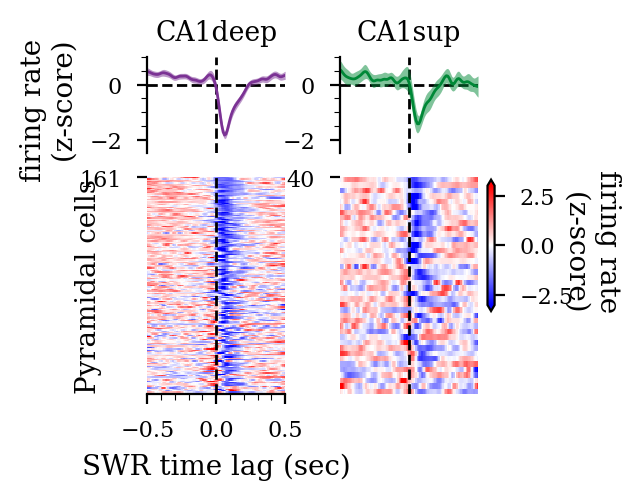

In [83]:
fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=.4, subplots=(1.5, 1)),
    constrained_layout=False,
)
gs = fig.add_gridspec(nrows=3, ncols=2, left=0.05, right=0.75, hspace=0.25, wspace=0.4)

y_min = -2.5
y_max = 1
heatmap_factor = 2
smooth_sigma = 0.02
smooth = True

group_colors = {
    "deep": "#7b3294",
    "sup": "#008837",
}

# # mean CI plots
ax0 = fig.add_subplot(gs[0, 0])
psth_df_temp = psth_df[
    np.where(
        cell_metrics.brainRegion.str.contains("CA1")
        & cell_metrics.deepSuperficial.str.contains("Deep")
    )[0]
]
center_val_deep = plot_psth_postive_negative(
    psth_df_temp, "deep", group_colors, ax0, smooth=smooth, smooth_sigma=smooth_sigma
)

ax1 = fig.add_subplot(gs[0, 1])
psth_df_temp = psth_df[
    np.where(
        cell_metrics.brainRegion.str.contains("CA1")
        & cell_metrics.deepSuperficial.str.contains("Superficial")
    )[0]
]
center_val_sup = plot_psth_postive_negative(
    psth_df_temp, "sup", group_colors, ax1, smooth=smooth, smooth_sigma=smooth_sigma
)


# plotting matrix of psth responses
ax2 = fig.add_subplot(gs[1:, 0])
psth_df_temp = psth_df[
    np.where(
        cell_metrics.brainRegion.str.contains("CA1")
        & cell_metrics.deepSuperficial.str.contains("Deep")
    )[0]
]
cell_metrics_temp = cell_metrics[
    cell_metrics.brainRegion.str.contains("CA1")
    & cell_metrics.deepSuperficial.str.contains("Deep")
]
plot_psth_matrix(psth_df_temp.iloc[:,center_val_deep<0], cell_metrics_temp[center_val_deep<0], "CA1", ax=ax2)


ax3 = fig.add_subplot(gs[1:, 1])
psth_df_temp = psth_df[
    np.where(
        cell_metrics.brainRegion.str.contains("CA1")
        & cell_metrics.deepSuperficial.str.contains("Superficial")
    )[0]
]
cell_metrics_temp = cell_metrics[
    cell_metrics.brainRegion.str.contains("CA1")
    & cell_metrics.deepSuperficial.str.contains("Superficial")
]
sm = plot_psth_matrix(psth_df_temp.iloc[:,center_val_sup<0], cell_metrics_temp[center_val_sup<0], "CA1", ax=ax3)


sns.despine()

axs = [ax0, ax1, ax2, ax3]
for i in range(len(axs)):
    axs[i].spines["top"].set_visible(False)
    axs[i].spines["right"].set_visible(False)
    axs[i].xaxis.set_minor_locator(AutoMinorLocator())
    axs[i].yaxis.set_minor_locator(AutoMinorLocator())

axs = [ax0, ax1]
for ax in axs:
    ax.spines["bottom"].set_visible(False)
    ax.axes.get_xaxis().set_ticks([])
    ax.axvline(0, linestyle="--", linewidth=1, alpha=1, color="k", zorder=-1000)

axs = [ax0, ax1, ax2, ax3]
for ax in axs:
    ax.axhline(0, linestyle="--", linewidth=1, alpha=1, color="k", zorder=-1000)

axs = [ax3]
for ax in axs:
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.axes.get_xaxis().set_ticks([])

ax2.spines["left"].set_visible(False)

ax0.set_ylabel("firing rate \n (z-score)")

ax2.set_xlabel("SWR time lag (sec)")
ax2.set_ylabel("Pyramidal cells", labelpad=-8)

ax0.set_ylim(y_min, y_max)
ax1.set_ylim(y_min, y_max)


cax = plt.axes([0.77, 0.3, 0.015, 0.3])
cbar = plt.colorbar(sm, cax=cax, extend="both")
cbar.set_label("firing rate \n (z-score)", rotation=270, labelpad=17)

ax0.set_title("CA1deep")
ax1.set_title("CA1sup")

plt.savefig(
    os.path.join(fig_save_path, "psth_ripple_deep_sup_negative_cells.svg"),
    dpi=300,
    bbox_inches="tight",
)

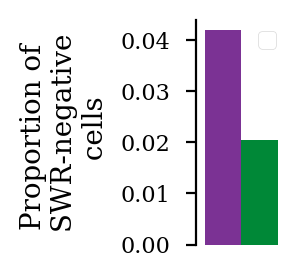

In [89]:

prop_df = pd.DataFrame()
prop_df["n_negative"] = np.array([sum(center_val_deep < 0), sum(center_val_sup < 0)])
prop_df["n_total"] = np.array([len(center_val_deep), len(center_val_sup)])
prop_df["prop"] = prop_df.n_negative / prop_df.n_total
prop_df["deepSuperficial"] = ["Deep", "Superficial"]
prop_df["constant"] = 1

group_colors = {"Deep": "#7b3294", "Superficial": "#008837"}
sns.set_palette(sns.color_palette(group_colors.values()))

fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.1, subplots=(4, 1)), edgecolor=None
)
sns.barplot(data=prop_df,x="constant",y="prop",hue="deepSuperficial",hue_order=group_colors.keys(),saturation=1)

sns.despine(bottom=True)
plt.legend("")
plt.ylabel("Proportion of \n SWR-negative \n cells")
# plt.gca().yaxis.set_minor_locator(AutoMinorLocator())
plt.gca().set_xticklabels([])
plt.gca().set_xticks([])
plt.gca().set_xlabel("")

plt.savefig(
    os.path.join(fig_save_path, "psth_ripple_deep_sup_negative_cells_prop.svg"),
    dpi=300,
    bbox_inches="tight",
)

In [90]:
from statsmodels.stats.proportion import proportions_ztest

count = [
    prop_df.query("deepSuperficial == 'Deep'").n_negative.sum(),
    prop_df.query("deepSuperficial == 'Superficial'").n_negative.sum(),
]
nobs = [
    prop_df.query("deepSuperficial == 'Deep'").n_total.sum(),
    prop_df.query("deepSuperficial == 'Superficial'").n_total.sum(),
]
stat, pval = proportions_ztest(count, nobs)
stat, pval

(4.242331817923933, 2.2120930288241455e-05)

In [91]:
prop_df

,n_negative,n_total,prop,deepSuperficial,constant
0,161,3849,0.041829,Deep,1
1,40,1966,0.020346,Superficial,1
